#LAB 6: Generative adversarial networks

<h4><div style="text-align: right"> Due date: 15:00 Dec 2, 2025.  </div> <br>
<div style="text-align: right"> Please upload your file and final-report at PLATO before the class in the form of [ID_Name_Lab6.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span>
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[202355514] [강지원]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2025-11-27 04:42:49.470692


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!tar -xvf /content/drive/MyDrive/lab6.tar

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
celebA/img_align_celeba/197600.jpg
celebA/img_align_celeba/197601.jpg
celebA/img_align_celeba/197602.jpg
celebA/img_align_celeba/197603.jpg
celebA/img_align_celeba/197604.jpg
celebA/img_align_celeba/197605.jpg
celebA/img_align_celeba/197606.jpg
celebA/img_align_celeba/197607.jpg
celebA/img_align_celeba/197608.jpg
celebA/img_align_celeba/197609.jpg
celebA/img_align_celeba/197610.jpg
celebA/img_align_celeba/197611.jpg
celebA/img_align_celeba/197612.jpg
celebA/img_align_celeba/197613.jpg
celebA/img_align_celeba/197614.jpg
celebA/img_align_celeba/197615.jpg
celebA/img_align_celeba/197616.jpg
celebA/img_align_celeba/197617.jpg
celebA/img_align_celeba/197618.jpg
celebA/img_align_celeba/197619.jpg
celebA/img_align_celeba/197620.jpg
celebA/img_align_celeba/197621.jpg
celebA/img_align_celeba/197622.jpg
celebA/img_align_celeba/197623.jpg
celebA/img_align_celeba/197624.jpg
celebA/img_align_celeba/197625.jpg
celebA/img_align_celeba/197626.jpg
celebA/img_align_ce

## 1. Implementation for DCGAN
> **1. Dataset**
>
>   * CelebA dataset
>   * Resize to (64, 64)
>
> **2. Network architecture**
>
>
>   * **Architecture Guideline**
>
> <img src="https://docs.google.com/uc?export=download&id=14gwes9TCu3Dy-CCu48yqa5gPtTi_6np-" alt="no_image" style="width: 700px;"/><br>
>
>
>
>   * **Generative model G**
>     * Xavier initialization (Glorot & Bengio [2])
>       * It makes sure the weights to keep the propagation in a reasonable range through many layers
>       * $V(W)= {2 \over n_in+n_out}$
>       * Use **nn.init.xavier_uniform_** for the Xavier initialization<br>
>       (The authors suggested a proper initialization for DCGAN training, but the xavier initialization also works well)
>     * Latent vector Z for input (size=100)<br>
>       (You need to make its size as (bs, 100, 1, 1) for upconvolution)
>
>     * They set the strides of upconvolutions to 5 but we will set the strides to 4 in this experiment
>
>     * Use the batch normalization except for the last layer
>
>
> <img src="https://docs.google.com/uc?export=download&id=1vXtAOUCIivvL-HWo1I8TUzZhDAFT8njk" alt="no_image" style="width: 800px;"/><br>
>
>
>   * **Discriminative model D**
>     * Xavier Initialization
>     * Real data or fake data for input (size=64x64)
>     * It's structure is the reverse version of the generative model G where the upconvolutions are replaced to convolutions and the last output size is changed to (bs, 1, 1, 1)
>     * Use the batch normalization except for the last layer
>
>
> **3. Loss function**
>  * **Discriminative model D**
>    * Binary cross entropy loss for the real data
>    * Binary cross entropy loss for the fake data <br>
>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{real}log(D(z_i))+(1-y_i^{real})log(1-D(z_i)) $ <br>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{fake}log(D(G(z_i)))+(1-y_i^{fake})log(1-D(G(z_i)))$ <br>
>
>    ($y_i^{real}=1, y_i^{fake}=0$)
>
>
>  * **Generative model G**
>    * Binary cross entropy loss for the real data (It is actually fake)
>
>    $-{1 \over N} \sum^{N}_{i=1} y_i^{real}log(D(G(z_i)))+(1-y_i^{real})log(1-D(G(z_i))) $ <br>
>
>    ($y_i^{real}=1$)
>
>
> **4. Training Strategy**
>    * Same as the GAN training algorithm
>    * The generative model G and the discriminative model D are trained alternatively during training
>    * When the parameters of the model D are being updated, the back-propagation in the model G is blocked

## 2. DCGAN with PyTorch

In [4]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import os.path as osp

%matplotlib inline

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Parameter Setting
* You can adjust the parameters to yourself

In [5]:
print('STEP 0: PARAMETER SETTING')

# Data root directory
data_root = '/content/celebA/'

# Batch size during training
bs = 128

# Size of image size
img_size = 64

# Channels of generator feature
gfc = 64

# Channels of discriminator feature
dfc = 64

# Size of latent vector z
z_size = 100

# Number of training epochs
num_epochs = 5

# Learning rate for optimizing
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Real or Fake label
real_label = 1
fake_label = 0

STEP 0: PARAMETER SETTING


In [6]:
print('STEP 1: LOADING DATASET')

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = dset.ImageFolder(root=data_root,
                           transform=transform)

STEP 1: LOADING DATASET


In [7]:
print('STEP 2: MAKING DATASET ITERABLE')

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=bs,
                                           shuffle=True,
                                           drop_last=True)

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

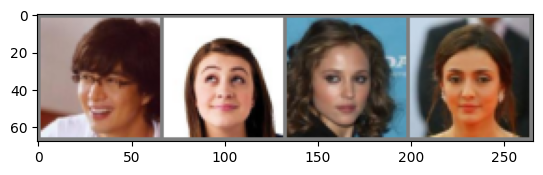

In [9]:
data_loader_sample = torch.utils.data.DataLoader(dataset=dataset,
                                                 batch_size=4,
                                                 shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(data_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

### Utils
* Use the below code for the convolutions or the upconvolutions

In [10]:
def conv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.Conv2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)

    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]

    return nn.Sequential(*layers)


def upconv2d(params_list, batch_norm = True):
    channel_in, channel_out, kernel_size, stride, padding, activation = params_list
    layers = []
    if batch_norm:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False),
                   nn.BatchNorm2d(channel_out)]
        nn.init.xavier_uniform_(layers[0].weight)
    else:
        layers += [nn.ConvTranspose2d(channel_in, channel_out, kernel_size, stride, padding, bias=False)]
        nn.init.xavier_uniform_(layers[0].weight)

    if activation == 'ReLU':
        layers += [nn.ReLU(inplace=True)]
    if activation == 'LeakyReLU':
        layers += [nn.LeakyReLU(0.2, inplace=True)]
    if activation == 'Tanh':
        layers += [nn.Tanh()]
    if activation == 'Sigmoid':
        layers += [nn.Sigmoid()]

    return nn.Sequential(*layers)

### 2.1 Write the code (Generator) [4 points]
* You need to set the hyperparameters for implementing the upconvolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [11]:
print('STEP 3-1: CREATE MODEL CLASS (Generator)')


# [input channels, output channels, kernel_size, strides, paddings, activation fuctions]
cfg_g = [[z_size, gfc * 8, 4, 1, 0, 'ReLU'],
        [gfc * 8, gfc * 4, 4, 2, 1, 'ReLU'],
        [gfc * 4, gfc * 2, 4, 2, 1, 'ReLU'],
        [gfc * 2, gfc, 4, 2, 1, 'ReLU'],
        [gfc, 3, 4, 2, 1, 'Tanh']]


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        #############
        # CODE HERE #
        #############

        self.layer1 = upconv2d(cfg_g[0], batch_norm = True)
        self.layer2 = upconv2d(cfg_g[1], batch_norm = True)
        self.layer3 = upconv2d(cfg_g[2], batch_norm = True)
        self.layer4 = upconv2d(cfg_g[3], batch_norm = True)
        self.layer5 = upconv2d(cfg_g[4], batch_norm = False)

    def forward(self, x):

        #############
        # CODE HERE #
        #############
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x

STEP 3-1: CREATE MODEL CLASS (Generator)


### 2.2 Write the code (Discriminator) [4 points]
* You need to set the hyperparameters for implementing the convolutions (params_list)
* There are 'ReLU', 'LeakyReLU', 'Tanh', and 'Sigmoid' for the activation functions
* If you do not want to use the activation function, just put '' in the position of the activation function
* Other parameters, such as paddings, can be determined by calculating the formulation of convolutional process<br>
  (See in https://pytorch.org/docs/stable/nn.html)
* You have to use the functions **conv2d()** or **upconv2d()** which are defined from above

In [12]:
print('STEP 3-2: CREATE MODEL CLASS (Discriminator)')


# [input channels, output channels, kernel_size, strides, paddings, activation fuctions]
cfg_d = [[3, dfc, 4, 2, 1, 'LeakyReLU'],
        [dfc, dfc * 2, 4, 2, 1, 'LeakyReLU'],
        [dfc * 2, dfc * 4, 4, 2, 1, 'LeakyReLU'],
        [dfc * 4, dfc * 8, 4, 2, 1, 'LeakyReLU'],
        [dfc * 8, 1, 4, 1, 0, 'Sigmoid']]


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #############
        # CODE HERE #
        #############

        self.layer1 = conv2d(cfg_d[0], batch_norm=False)
        self.layer2 = conv2d(cfg_d[1], batch_norm=True)
        self.layer3 = conv2d(cfg_d[2], batch_norm=True)
        self.layer4 = conv2d(cfg_d[3], batch_norm=True)
        self.layer5 = conv2d(cfg_d[4], batch_norm=False)

    def forward(self, x):

        #############
        # CODE HERE #
        #############

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x


STEP 3-2: CREATE MODEL CLASS (Discriminator)


In [13]:
print('STEP 4: INSTANTIATE MODEL CLASS')


model_G = Generator()
model_D = Discriminator()


#######################
#  USE GPU FOR MODEL  #
#######################


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_G.to(device)
print(model_G)
model_D.to(device)

STEP 4: INSTANTIATE MODEL CLASS
Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d

In [14]:
print('STEP 5: INSTANTIATE LOSS CLASS')

criterion = nn.BCELoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')

optimizer_G = torch.optim.Adam(model_G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(model_D.parameters(), lr=lr, betas=(beta1, 0.999))

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 2.3 Train the DCGAN [2 points]
* After the training is finished, check out the generated samples
* If the samples are generated well, then you will get the full score

STEP 7: TRAIN THE MODEL
[0/5][400/1582]	Loss_D: 0.5431	Loss_G: 2.5747	
[0/5][800/1582]	Loss_D: 0.3403	Loss_G: 3.1823	
[0/5][1200/1582]	Loss_D: 0.3304	Loss_G: 3.6363	
[1/5][400/1582]	Loss_D: 0.4648	Loss_G: 5.4050	
[1/5][800/1582]	Loss_D: 0.7166	Loss_G: 2.0687	
[1/5][1200/1582]	Loss_D: 0.5258	Loss_G: 3.7062	
[2/5][400/1582]	Loss_D: 0.4770	Loss_G: 1.6857	
[2/5][800/1582]	Loss_D: 1.4553	Loss_G: 0.7443	
[2/5][1200/1582]	Loss_D: 0.3614	Loss_G: 2.9843	
[3/5][400/1582]	Loss_D: 0.9266	Loss_G: 4.5379	
[3/5][800/1582]	Loss_D: 0.3410	Loss_G: 3.2228	
[3/5][1200/1582]	Loss_D: 0.4651	Loss_G: 3.5349	
[4/5][400/1582]	Loss_D: 0.3570	Loss_G: 2.0343	
[4/5][800/1582]	Loss_D: 2.3211	Loss_G: 3.8328	
[4/5][1200/1582]	Loss_D: 0.6313	Loss_G: 2.3734	


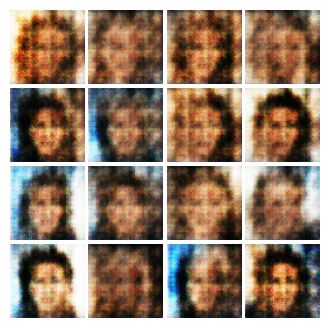

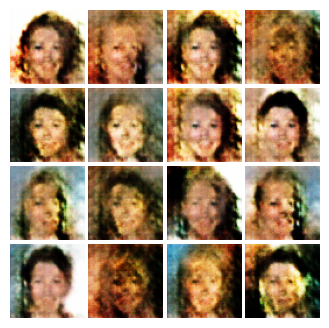

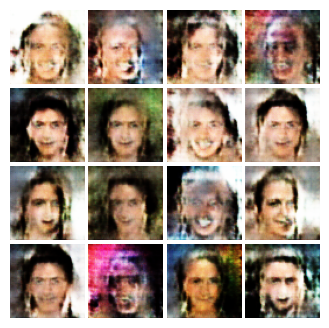

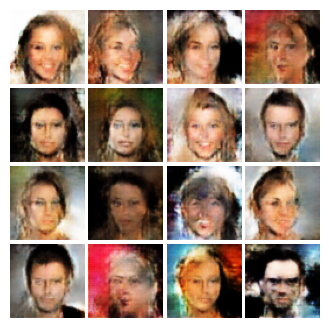

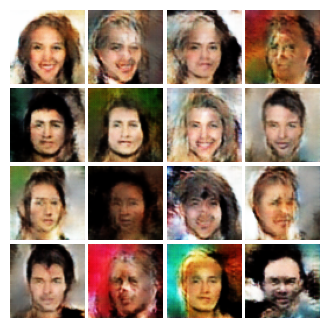

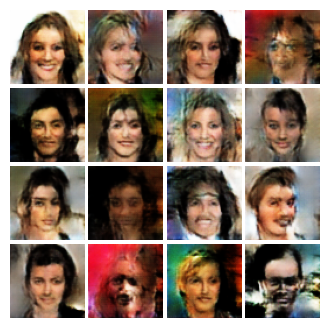

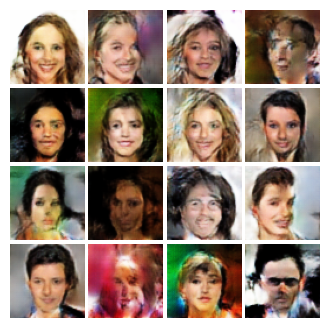

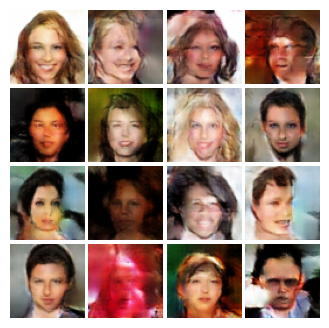

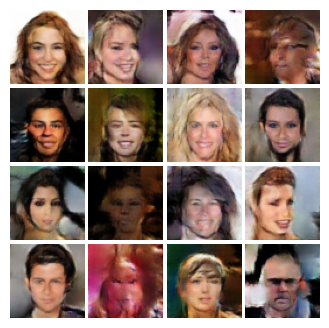

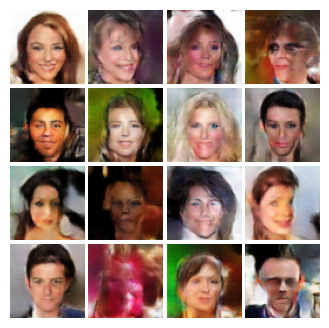

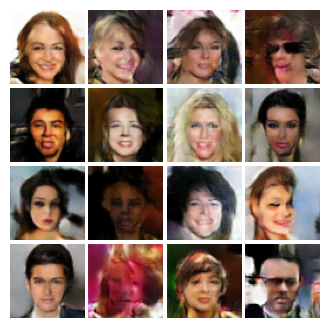

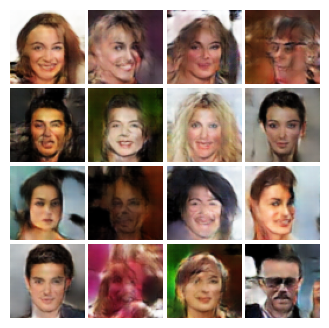

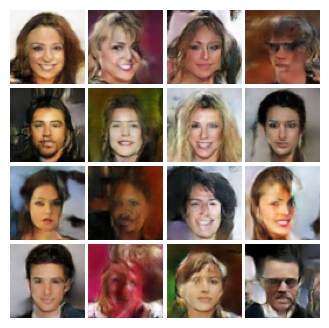

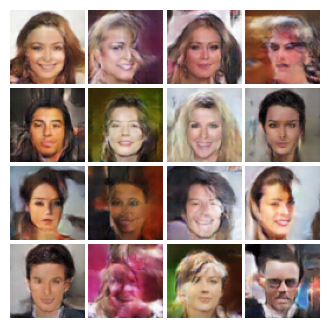

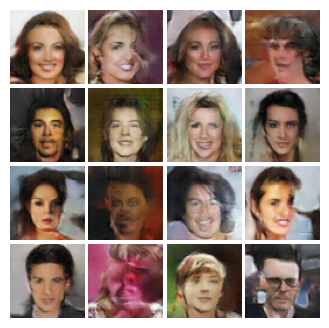

In [15]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64, 3), cmap='Greys_r')
    return fig

print('STEP 7: TRAIN THE MODEL')

label_real = torch.full((bs,), real_label, dtype=torch.float, device=device)
label_fake = torch.full((bs,), fake_label, dtype=torch.float, device=device)

#  The input noise for inference
fixed_noise = torch.randn(bs, z_size, 1, 1, device=device)

for epoch in range(num_epochs):

    model_G.train()
    model_D.train()

    for i, data in enumerate(data_loader):

        data = data[0].to(device)

        ### Update discriminator model

        # Clear gradients w.r.t. parameters
        model_D.zero_grad()

        # Forward pass to get results of discriminator for real data
        output_D_real = model_D(data).view(-1)

        # Calculate Loss
        err_D_real = criterion(output_D_real, label_real)

        # Generating noise inputs for generating fake samples
        noise = torch.randn(bs, z_size, 1, 1, device=device)

        # Forward pass to get generated samples
        output_G = model_G(noise)

        # Forward pass to get results of discriminator for fake data
        output_D_fake = model_D(output_G.detach()).view(-1)

        # Calculate Loss
        err_D_fake = criterion(output_D_fake, label_fake)

        # Combine the losses for real data and fake data
        err_D = err_D_real + err_D_fake

        # Getting gradients w.r.t. parameters
        err_D.backward()

        # Updating parameters
        optimizer_D.step()


        ### Update generator model

        # Clear gradients w.r.t. parameters
        model_G.zero_grad()

        # Forward pass to get results of discriminator for fake data
        output_G_real = model_D(output_G).view(-1)

        # Calculate Loss
        err_G = criterion(output_G_real, label_real)

        # Getting gradients w.r.t. parameters
        err_G.backward()

        # Updating parameters
        optimizer_G.step()

        # Output training stats
        if i % 400 == 0 and i != 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(data_loader),
                     err_D.item(), err_G.item()))

            model_G.eval()
            model_D.eval()
            with torch.no_grad():
                output = model_G(fixed_noise).detach().cpu().numpy()
                output = np.transpose((output+1)/2, (0, 2, 3, 1))
                fig = plot(output[:16])

            model_G.train()
            model_D.train()


### *References*
[1] Radford et al., "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial network", *ICLR*, 2016. <br>
[2] Glorot & Bengio, "Understanding the difficulty of training deep feedforward neural networks", *AISTATS* 2010 <br>